In [ ]:
pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 6.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import minimize

In [ ]:
aapl = yf.Ticker('aapl')
aapl

yfinance.Ticker object <AAPL>

In [ ]:
aapl.options

('2022-12-09',
 '2022-12-16',
 '2022-12-23',
 '2022-12-30',
 '2023-01-06',
 '2023-01-20',
 '2023-02-17',
 '2023-03-17',
 '2023-04-21',
 '2023-05-19',
 '2023-06-16',
 '2023-07-21',
 '2023-09-15',
 '2024-01-19',
 '2024-03-15',
 '2024-06-21',
 '2025-01-17')

In [ ]:
opt = aapl.option_chain(date = '2022-12-16')
opt_calls = pd.DataFrame(opt.calls)
opt_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL221216C00030000,2022-11-29 16:39:22+00:00,30.0,112.00,117.50,118.25,0.000000,0.00000,1,2,3.296877,True,REGULAR,USD
1,AAPL221216C00035000,2022-11-11 15:15:22+00:00,35.0,112.30,112.50,113.25,0.000000,0.00000,4,22,2.984378,True,REGULAR,USD
2,AAPL221216C00040000,2022-12-02 18:53:22+00:00,40.0,106.66,107.50,108.20,-5.619995,-5.00534,4,389,2.578129,True,REGULAR,USD
3,AAPL221216C00045000,2022-11-02 18:35:32+00:00,45.0,106.50,102.50,103.15,0.000000,0.00000,238,483,2.125005,True,REGULAR,USD
4,AAPL221216C00050000,2022-11-18 20:46:59+00:00,50.0,101.73,97.55,98.20,0.000000,0.00000,2,331,2.265629,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,AAPL221216C00270000,2022-11-18 15:04:00+00:00,270.0,0.01,0.00,0.01,0.000000,0.00000,1,2446,0.968750,False,REGULAR,USD
63,AAPL221216C00275000,2022-09-23 19:41:05+00:00,275.0,0.01,0.00,0.01,0.000000,0.00000,1500,3742,0.984375,False,REGULAR,USD
64,AAPL221216C00280000,2022-11-28 14:30:11+00:00,280.0,0.01,0.00,0.01,0.000000,0.00000,6,4898,1.031255,False,REGULAR,USD
65,AAPL221216C00285000,2022-10-05 14:08:22+00:00,285.0,0.01,0.00,0.01,0.000000,0.00000,3,1591,1.062505,False,REGULAR,USD


In [ ]:
class BlackScholes:
    """ 
    Class to calculate (European) call and put option prices through the Black-Scholes formula 
    without dividends
    
    :param S: Price of underlying stock
    :param K: Strike price
    :param T: Time till expiration (in years)
    :param r: Risk-free interest rate (0.05 indicates 5%)
    :param sigma: Volatility (standard deviation) of stock (0.15 indicates 15%)
    """
    def _d1(self, S, K, T, r, sigma):
        return (1 / (sigma * np.sqrt(T))) * (np.log(S/K) + (r + sigma**2 / 2) * T)
    
    def _d2(self, S, K, T, r, sigma):
        return self._d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
    def call_price(self, S, K, T, r, sigma):
        """ Main method for calculating price of a call option """
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r*T)
    
    def put_price(self, S, K, T, r, sigma):
        """ Main method for calculating price of a put option """
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(-d2) * K * np.exp(-r*T) - norm.cdf(-d1) * S
    
    def call_in_the_money(self, S, K, T, r, sigma):
        """ 
        Calculate probability that call option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(d2)
    
    def put_in_the_money(self, S, K, T, r, sigma):
        """ 
        Calculate probability that put option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma)
        return 1 - norm.cdf(d2)

In [ ]:
S = 149.70 # Stock price
K = 160 # Strike price
T = 34/365 # Time till expiration (in years)
r = 0.03819 # Risk-free interest rate
sigma = opt_calls['impliedVolatility'][26] # Volatility (standard deviation)
sigma

0.35034829345703117

In [ ]:
BlackScholes().call_price(S, K, T, r, sigma)

2.8342555700533936

In [ ]:
traded_price = opt_calls['lastPrice'][26]
traded_price

5.97

### Comparing option contracts of different maturity dates

Volumes of option contracts (Calls/Puts)



In [ ]:
# Obtain a tuple of expiration dates
exp = aapl.options

# Convert a tuple into a list
exp = list(exp)

dates = []
for i in range(0,len(exp)):
  date = datetime.strptime(exp[i], "%Y-%m-%d")
  dates.append(date)

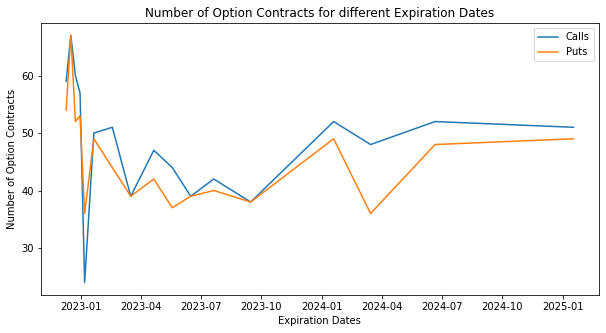

In [ ]:
# Create a plot for the number of option contracts for different expiration dates throughout the year (CALLS/PUTS)

# Count the number of calls and puts for each expiration date and store into a list
counts_call = []
for i in exp:
  opt = aapl.option_chain(date = i)
  opt_calls = pd.DataFrame(opt.calls)
  counts_call.append(len(opt_calls))

counts_put = []
for i in exp:
  opt = aapl.option_chain(date = i)
  opt_puts = pd.DataFrame(opt.puts)
  counts_put.append(len(opt_puts))

# Plot a time series line graph for call and put options
plt.figure(figsize=(10,5))
plt.title('Number of Option Contracts for different Expiration Dates')
plt.xlabel('Expiration Dates')
plt.ylabel('Number of Option Contracts')
plt.plot(dates, counts_call, label = 'Calls')
plt.plot(dates, counts_put, label = 'Puts')
plt.legend(loc = "upper right")
plt.show()

Strike Price Distributions

In [ ]:
opt1 = aapl.option_chain(date = '2022-12-16')
opt_call1 = pd.DataFrame(opt.calls)
print(opt_call1)

         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0   AAPL250117C00050000 2022-12-02 16:29:32+00:00    50.0     100.54  99.65   
1   AAPL250117C00055000 2022-12-02 14:45:04+00:00    55.0      96.50  95.60   
2   AAPL250117C00060000 2022-12-01 20:26:56+00:00    60.0      93.84  91.55   
3   AAPL250117C00065000 2022-12-02 20:13:51+00:00    65.0      89.80  87.35   
4   AAPL250117C00070000 2022-11-30 15:55:51+00:00    70.0      79.53  83.40   
5   AAPL250117C00075000 2022-12-01 18:27:43+00:00    75.0      82.00  79.95   
6   AAPL250117C00080000 2022-11-30 15:03:53+00:00    80.0      72.00  76.15   
7   AAPL250117C00085000 2022-11-28 19:41:01+00:00    85.0      70.13  72.20   
8   AAPL250117C00090000 2022-11-30 20:27:00+00:00    90.0      69.20  68.45   
9   AAPL250117C00095000 2022-11-30 19:33:59+00:00    95.0      65.33  64.85   
10  AAPL250117C00100000 2022-12-02 20:06:19+00:00   100.0      61.97  62.00   
11  AAPL250117C00105000 2022-11-30 19:41:13+00:00   

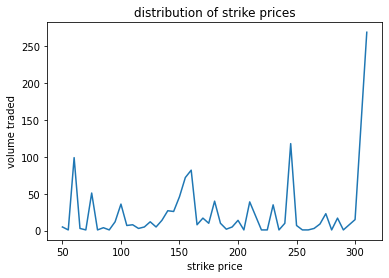

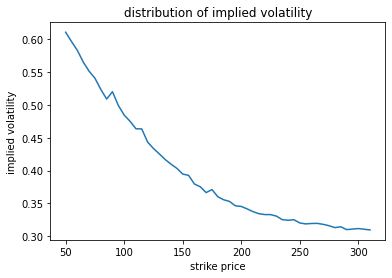

In [ ]:
plt.plot(opt_call1['strike'], opt_call1['volume'])
plt.xlabel('strike price')
plt.ylabel('volume traded')
plt.title('distribution of strike prices')
plt.show()

plt.plot(opt_call1['strike'], opt_call1['impliedVolatility'])
plt.xlabel('strike price')
plt.ylabel('implied volatility')
plt.title('distribution of implied volatility')
plt.show()